This notebook is my implementation of the Neural Collabrative Filtering Recoomendation system. 
[NCF](https://arxiv.org/abs/1708.05031) models has other implementation, such as the [author's original implementation in theano](https://github.com/hexiangnan/neural_collaborative_filtering), the [offical tensorflow/keras version](https://github.com/tensorflow/models/tree/master/official/recommendation) and a [pytorch version](
https://towardsdatascience.com/recotour-ii-neural-recommendation-algorithms-49733938d56e) with a [video](https://www.youtube.com/watch?v=O4lk9Lw7lS0) explaining it. In this notebook, I write the code so that it can be followed in a single google colab notebook with step by step instructuion

In [0]:
# !kill -9 -1xw

### 1. Download data

In [280]:
!curl -O 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!unzip ml-100k.zip
!mkdir -p data

!cp ml-100k/u.data data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  12.4M      0 --:--:-- --:--:-- --:--:-- 12.3M
Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import pandas as pd
import numpy as np

In [282]:
import os
os.getcwd()

'/content'

In [0]:
input_file = 'data/u.data'
headers = ['user_id', 'item_id', 'rating', 'timestamp']
header_row = None
ratings_df = pd.read_csv(input_file,
                         sep='\t',
                         names=headers,
                         header=header_row,
                         dtype={
                           'user_id': np.int32,
                           'item_id': np.int32,
                           'rating': np.float32,
                           'timestamp': np.int32,
                         })

In [284]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


### 2. Preprocess the data

In [0]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [0]:
user_enc = LabelEncoder()
product_enc = LabelEncoder()
scaler = MinMaxScaler()

ratings_df['user_id'] = user_enc.fit_transform(ratings_df['user_id'].values)
ratings_df['item_id'] = product_enc.fit_transform(ratings_df['item_id'].values)
ratings_df['rating'] = scaler.fit_transform(ratings_df['rating'].values.reshape(-1, 1))

In [287]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,195,241,0.50,881250949
1,185,301,0.50,891717742
2,21,376,0.00,878887116
3,243,50,0.25,880606923
4,165,345,0.00,886397596


In [0]:
n_users = len(ratings_df['user_id'].unique())
n_items = len(ratings_df['item_id'].unique())

In [289]:
print('number of unique user {}'.format(n_users))
print('number of unique movie {}'.format(n_items))

number of unique user 943
number of unique movie 1682


In [290]:
ratings_df['user_id'].min() # make sure index start from 0

0

In [0]:
ratings = ratings_df[['user_id','item_id','rating']].to_numpy()

In [0]:
from sklearn.model_selection import train_test_split

tr_ratings, ts_ratings = train_test_split(ratings, test_size = 0.1)
X_train = [[tr_ratings[:,0],tr_ratings[:,1]]]
y_train = tr_ratings[:,2].reshape(-1,1)

X_test = [[ts_ratings[:,0],ts_ratings[:,1]]]
y_test = ts_ratings[:,2].reshape(-1,1)

In [0]:
## convert the rating matrix to a sparse matrix

# from scipy.sparse import coo_matrix
# u_tr, i_tr, r_tr = zip(*tr_ratings)
# tr_sparse = coo_matrix((r_tr, (u_tr, i_tr)), shape=(n_users, n_items))

# u_ts, i_ts, r_ts = zip(*ts_ratings)
# test_sparse = coo_matrix((r_ts, (u_ts, i_ts)), shape=(n_users, n_items))

### 3. build the model

Note that the neural collaborative filtering (NCF) model is a combination of the generalized matrix factorization model(GMF) and the multilayer perception model(MLP). We can build each model first and then concatenate them. In fact, in the original paper, it shows that by pretraining each model then used the pretrained weight as initialiation point for the final model, you can reach a higher accuracy. 
![](https://drive.google.com/uc?id=1RqXBiGTCPFRpSkcTfpB7WgpYOXZyuXhx)

In [294]:
import tensorflow as tf
print(tf.__version__)

2.2.0


**Part 1, build the GMF model**

In [0]:
def build_GMF(embedding_dim, n_users, n_items):
  # Input layers
  user_input = tf.keras.layers.Input(shape=(1,)) # user
  product_input = tf.keras.layers.Input(shape=(1,)) # movie
  # Embedding layers
  User_embedding = tf.keras.layers.Embedding(n_users, embedding_dim,\
                                             embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
  Product_embedding = tf.keras.layers.Embedding(n_items, embedding_dim, \
                                                embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)
  # Dot products
  u = tf.keras.layers.Reshape((embedding_dim,))(User_embedding)
  v = tf.keras.layers.Reshape((embedding_dim,))(Product_embedding)
  s = tf.keras.layers.Dot(axes=1)([u, v])
  model = tf.keras.Model(inputs=[user_input, product_input], outputs=s)
  print(model.summary())
  return(model)


In [296]:
embedding_dim = 10
GMF_model = build_GMF(embedding_dim, n_users, n_items)

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_97 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_98 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_114 (Embedding)       (None, 1, 10)        9430        input_97[0][0]                   
__________________________________________________________________________________________________
embedding_115 (Embedding)       (None, 1, 10)        16820       input_98[0][0]                   
___________________________________________________________________________________________

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [298]:
opt = tf.keras.optimizers.Adagrad(learning_rate=0.5)  #Use Adagrad to get faster learning rate
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)  

GMF_model.compile(loss='mean_squared_error', optimizer=opt)

history = GMF_model.fit(x=X_train, y=y_train,
                  batch_size=64, epochs=500,
                  validation_data= (X_test, y_test),
                  callbacks=[checkpoint_callback, es])

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1407/1407 [==============================] - 2s 2ms/step - loss: 0.4507 - val_loss: 0.2830
Epoch 2/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.1315 - val_loss: 0.0786
Epoch 3/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0696 - val_loss: 0.0635
Epoch 4/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0613 - val_loss: 0.0602
Epoch 5/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0581 - val_loss: 0.0582
Epoch 6/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0560 - val_loss: 0.0566
Epoch 7/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0542 - val_loss: 0.0559
Epoch 8/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0525 - val_loss: 0.0553
Epoch 9/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0509 - val_loss: 0.0550
Epoch 10/500
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0494 

In [0]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

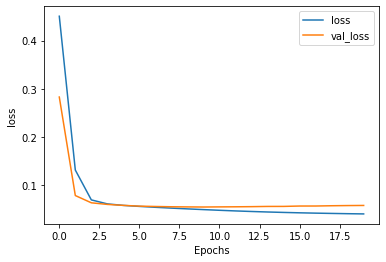

In [300]:
plot_graph(history, "loss")

As we can see, we should use the model somewhere around the 10th epoches, we can load the saved weight from checkpoint file

In [301]:
recovered_model = build_GMF(embedding_dim, n_users, n_items)
recovered_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
recovered_model.build(tf.TensorShape([1, None]))

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_100 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_116 (Embedding)       (None, 1, 10)        9430        input_99[0][0]                   
__________________________________________________________________________________________________
embedding_117 (Embedding)       (None, 1, 10)        16820       input_100[0][0]                  
___________________________________________________________________________________________

In [0]:
prediction = recovered_model(X_test)

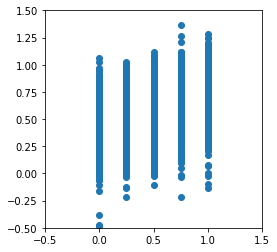

In [303]:
plt.plot(y_test,prediction,'o')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

One can also add a bias layer, which represent the average score for each users, and the average score for each item

In [0]:
def build_bias(embedding_dim, n_users, n_items):
  # Input layers
  user_input = tf.keras.layers.Input(shape=(1,)) # user
  product_input = tf.keras.layers.Input(shape=(1,)) # movie
  # Embedding layers
  User_embedding = tf.keras.layers.Embedding(n_users, embedding_dim,\
                                             embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
  
  User_embedding_avg = tf.keras.layers.Embedding(n_users, 1,embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
 

  Product_embedding = tf.keras.layers.Embedding(n_items, embedding_dim,\
                                             embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)
  
  Product_embedding_avg = tf.keras.layers.Embedding(n_items, 1,embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)
 
  
  # Dot products
  u = tf.keras.layers.Reshape((embedding_dim,))(User_embedding)
  v = tf.keras.layers.Reshape((embedding_dim,))(Product_embedding)
  s = tf.keras.layers.Dot(axes=1)([u, v])

  o = tf.keras.layers.Add()([s, User_embedding_avg, Product_embedding_avg])

  model = tf.keras.Model(inputs=[user_input, product_input], outputs=o)
  print(model.summary())
  return(model)

**Part 2, build the MLP model**

We will be using two embedding layer (one for user and one for item), and 3 fully connective layers with size of [16,8,4]

In [0]:
def build_MLP(embedding_dim, n_users, n_items):
  # Input layers
  user_input_mlp = tf.keras.layers.Input(shape=(1,)) # user
  product_input_mlp = tf.keras.layers.Input(shape=(1,)) # movie
  # Embedding layers
  User_embedding_mlp = tf.keras.layers.Embedding(n_users, embedding_dim,
                                                 embeddings_initializer= "normal",
                                                  embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input_mlp)
  Product_embedding_mlp = tf.keras.layers.Embedding(n_items, embedding_dim, 
                                                    embeddings_initializer= "normal",
                                                    embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input_mlp)
  # Concatenation of the two embedding
  # u_mlp = tf.keras.layers.Flatten()(User_embedding_mlp)
  # v_mlp = tf.keras.layers.Flatten()(Product_embedding_mlp)

  u_mlp =tf.keras.layers.Reshape((embedding_dim,))(User_embedding_mlp)
  v_mlp = tf.keras.layers.Reshape((embedding_dim,))(Product_embedding_mlp)

  u_mlp = tf.keras.layers.Dropout(0.5)(u_mlp)
  v_mlp = tf.keras.layers.Dropout(0.5)(v_mlp)

  merged = tf.keras.layers.Concatenate(axis=1)([u_mlp, v_mlp])

  fcn = tf.keras.layers.Dense(64, activation='relu',\
                              kernel_regularizer=tf.keras.regularizers.l2(1e-6),
                              activity_regularizer = tf.keras.regularizers.l2(1e-6))(merged)

  fcn = tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

  fcn = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)
  fcn = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

  output_mlp = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer="lecun_uniform")(fcn)

  model = tf.keras.Model(inputs=[user_input_mlp, product_input_mlp], outputs=output_mlp)
  print(model.summary())
  return(model)

In [408]:
embedding_dim = 100
MLP_model = build_MLP(embedding_dim, n_users, n_items)

Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_165 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_166 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_180 (Embedding)       (None, 1, 100)       94300       input_165[0][0]                  
__________________________________________________________________________________________________
embedding_181 (Embedding)       (None, 1, 100)       168200      input_166[0][0]                  
___________________________________________________________________________________________

In [406]:
# opt = tf.keras.optimizers.Adagrad(learning_rate=0.01)  #Use Adagrad to get faster learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.001)  

MLP_model.compile(loss='mean_squared_error', optimizer=opt)

history = MLP_model.fit(x=X_train, y=y_train,
                  batch_size=64, epochs=500,
                  validation_data= (X_test, y_test),
                  callbacks=[checkpoint_callback, es])

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


InvalidArgumentError: ignored

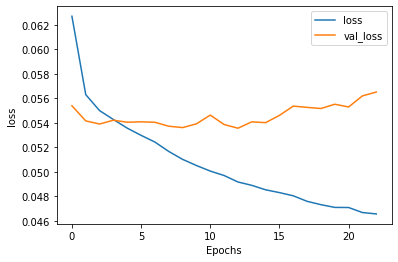

In [400]:
plot_graph(history, "loss")

In [401]:
recovered_model = build_GMF(embedding_dim, n_users, n_items)
recovered_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
recovered_model.build(tf.TensorShape([1, None]))

Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_159 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_160 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_174 (Embedding)       (None, 1, 100)       94300       input_159[0][0]                  
__________________________________________________________________________________________________
embedding_175 (Embedding)       (None, 1, 100)       168200      input_160[0][0]                  
___________________________________________________________________________________________

In [0]:
prediction = recovered_model(X_test)

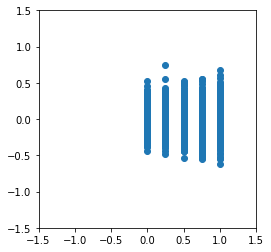

In [396]:
plt.plot(y_test,prediction,'o')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

**Part3 NCF: combining part1 and part2**

In [0]:
def build_NCF(embedding_dim, n_users, n_items):
  user_input = tf.keras.layers.Input(shape=(1,)) # user
  product_input = tf.keras.layers.Input(shape=(1,)) # movie

  # Embedding of GMF
  User_embedding_gmf = tf.keras.layers.Embedding(n_users, embedding_dim,\
                                             embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
  Product_embedding_gmf = tf.keras.layers.Embedding(n_items, embedding_dim, \
                                                embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)

  # Embedding of MLP
  User_embedding_mlp = tf.keras.layers.Embedding(n_users, embedding_dim,
                                            embeddings_initializer= "normal",
                                            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user_input)
  Product_embedding_mlp = tf.keras.layers.Embedding(n_items, embedding_dim, 
                                                    embeddings_initializer= "normal",
                                                    embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(product_input)

  # GMF: Matrix Multiplication
  u = tf.keras.layers.Flatten()(User_embedding_gmf)
  v = tf.keras.layers.Flatten()(Product_embedding_gmf)
  output_gmf = tf.keras.layers.Dot(axes=1)([u, v])

  # MLP: Concatenation of the two embedding
  u_mlp = tf.keras.layers.Flatten()(User_embedding_mlp)
  v_mlp = tf.keras.layers.Flatten()(Product_embedding_mlp)

  u_mlp = tf.keras.layers.Dropout(0.5)(u_mlp)
  v_mlp = tf.keras.layers.Dropout(0.5)(v_mlp)

  merged_mlp = tf.keras.layers.Concatenate(axis=1)([u_mlp, v_mlp])


  fcn = tf.keras.layers.Dense(64, activation='relu',\
                              kernel_regularizer=tf.keras.regularizers.l2(1e-6),
                              activity_regularizer = tf.keras.regularizers.l2(1e-6))(merged_mlp)

  fcn = tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

  fcn = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)
  output_mlp = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(fcn)

  #merge two output
  merged = tf.keras.layers.Concatenate(axis=1)([output_mlp, output_gmf])
  output = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer="lecun_uniform")(merged)

  model = tf.keras.Model(inputs=[user_input, product_input], outputs=output)
  print(model.summary())
  return(model)

In [414]:
embedding_dim = 100
NCF_model = build_NCF(embedding_dim, n_users, n_items)

Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_169 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_170 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_188 (Embedding)       (None, 1, 100)       94300       input_169[0][0]                  
__________________________________________________________________________________________________
embedding_189 (Embedding)       (None, 1, 100)       168200      input_170[0][0]                  
___________________________________________________________________________________________

In [416]:
opt = tf.keras.optimizers.Adagrad(learning_rate=0.5)  #Use Adagrad to get faster learning rate
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)  

NCF_model.compile(loss='mean_squared_error', optimizer=opt)

history = NCF_model.fit(x=X_train, y=y_train,
                  batch_size=64, epochs=500,
                  validation_data= (X_test, y_test),
                  callbacks=[checkpoint_callback, es])

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1407/1407 [==============================] - 8s 6ms/step - loss: 0.0730 - val_loss: 0.0608
Epoch 2/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0607 - val_loss: 0.0563
Epoch 3/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0581 - val_loss: 0.0553
Epoch 4/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0568 - val_loss: 0.0551
Epoch 5/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0558 - val_loss: 0.0539
Epoch 6/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0553 - val_loss: 0.0539
Epoch 7/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0548 - val_loss: 0.0539
Epoch 8/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0543 - val_loss: 0.0535
Epoch 9/500
1407/1407 [==============================] - 8s 5ms/step - loss: 0.0538 - val_loss: 0.0535
Epoch 10/500
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0536 

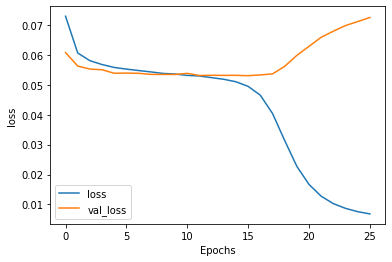

In [417]:
plot_graph(history, "loss")

In [418]:
recovered_model = build_NCF(embedding_dim, n_users, n_items)
recovered_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
recovered_model.build(tf.TensorShape([1, None]))

Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_171 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_172 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_192 (Embedding)       (None, 1, 100)       94300       input_171[0][0]                  
__________________________________________________________________________________________________
embedding_193 (Embedding)       (None, 1, 100)       168200      input_172[0][0]                  
___________________________________________________________________________________________

In [0]:
prediction = recovered_model(X_test)

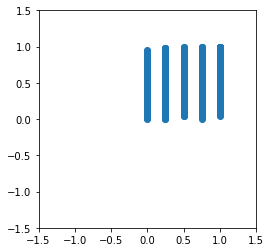

In [420]:
plt.plot(y_test,prediction,'o')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')